# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Descargando el conjunto de datos

In [76]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup, 200k usado para checkout_final_improved.pt
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [77]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

# Cargadores de datos

In [78]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [79]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)
    debug_mode : bool = field(default=False)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32 # 64 usado para checkout_final_improved.pt
    batch_size: int = 8
    n_embd: int = 64 # 128 usado para checkout_final_improved.pt
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 64, 'batch_size': 8, 'n_embd': 128, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 62, 'bias': True, 'ff_class': None, 'moe': None}


In [87]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 2, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 2,
                        )

In [81]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [82]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [29]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [83]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [47]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [88]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [89]:
optimizer = AdamW(model.parameters(), lr=1e-3) # 3e-4 usado para checkout_final_improved.pt
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2 # 5 usado para checkout_final_improved.pt

# Entrenamiento

In [90]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 2.21267: 100%|██████████| 22492/22492 [06:20<00:00, 59.05it/s]


Época 1 - pérdida de entrenamiento: 2.2195


val_loss 2.36674: 100%|██████████| 2492/2492 [00:18<00:00, 138.34it/s]


Época 1 - pérdida de validación: 2.3358


loss 2.24611: 100%|██████████| 22492/22492 [06:15<00:00, 59.88it/s]


Época 2 - pérdida de entrenamiento: 2.2322


val_loss 2.36674: 100%|██████████| 2492/2492 [00:17<00:00, 140.13it/s]


Época 2 - pérdida de validación: 2.3358


loss 2.23724: 100%|██████████| 22492/22492 [06:15<00:00, 59.96it/s]


Época 3 - pérdida de entrenamiento: 2.2458


val_loss 2.36674: 100%|██████████| 2492/2492 [00:17<00:00, 141.36it/s]


Época 3 - pérdida de validación: 2.3358


loss 2.27420: 100%|██████████| 22492/22492 [06:14<00:00, 59.99it/s]


Época 4 - pérdida de entrenamiento: 2.2619


val_loss 2.36674: 100%|██████████| 2492/2492 [00:17<00:00, 139.36it/s]


Época 4 - pérdida de validación: 2.3358


loss 2.24564: 100%|██████████| 22492/22492 [06:15<00:00, 59.85it/s]


Época 5 - pérdida de entrenamiento: 2.2435


val_loss 2.36674: 100%|██████████| 2492/2492 [00:18<00:00, 136.60it/s]


Época 5 - pérdida de validación: 2.3358
Entrenamiento completo.


### Prueba rápida

In [15]:
generate("To be", max_new_tokens=100, use_cache=True)

"To bechinghy 'to sportim:\nThiug bled were sobus hald thably, !\nHet Vt\nMith the canignd thet\nId hetir atho"

In [16]:
generate("To be", max_new_tokens=100, use_cache=True)

'To beohe for pere benges\nbllend iten shat me thathaple mpemits his orstht fratire ave he sein your mands\n'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [17]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
)-> Optional[str]:
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for step in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :]

        # Escalado de temperatura
        if temperature == 0:
            pass
        else:
            logits = logits / temperature

        # Top-k
        if top_k is not None:
            values, _ = torch.topk(logits, top_k)
            min_values = values[:, -1].unsqueeze(1)

            # Reemplazar por -inf
            logits = torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)

        # Top-p filtering
        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            probs = F.softmax(sorted_logits, dim=-1)
            cumulative_probs = torch.cumsum(probs, dim=-1)

            # Filtrar tokens fuera del núcleo top_p
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = False

            # Reemplazar por -inf
            for i in range(logits.size(0)):
                logits[i, sorted_indices[i, sorted_indices_to_remove[i]]] = float('-inf')

        # Selección de token
        if temperature == 0:
            # Greedy
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [18]:
result_1 = generate("To be", max_new_tokens=100, use_cache=True)

In [19]:
print(result_1)

To betan'd thitem, sto Seed out hy Cand cat pen If hiver
He.

ORIOMNINIOLUMNId
PNUS:
Thes thion thes I ha


In [20]:
result_greedy = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=0, top_k=None, top_p=None)

In [21]:
result_greedy

'To be the the the the the the the the the the the the the the the the the the the the the the the the the'

In [22]:
result_top_k_10 = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=10, top_p=None)

In [23]:
result_top_k_10

'To be ied\nMA itortin: as be mofese de, bare sheade onds mous and shen has. Cor we watherther,\nThot tas hi'

In [24]:
result_top_p_50 = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=None, top_p=0.5)

In [25]:
result_top_p_50

'To ben the shart or sound he she thar the son the the and there the there mat ares wis here the were ater'

Dejamos este código disponible para cargar el modelo guardado sin tener que volver a entrenar:

In [26]:
m = TinyGPT(config).to(device)
model = torch.compile(m)

checkpoint = torch.load("./checkpoints/checkpoint_final.pt", map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

OptimizedModule(
  (_orig_mod): TinyGPT(
    (token_emb): Embedding(61, 64)
    (pos_emb): Embedding(32, 64)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x AttentionHead(
              (key_query_value): Linear(in_features=64, out_features=48, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (proj): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): ReLU()
            (2): Linear(in_features=256, out_features=64, bias=True)
            (3): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    

### Análisis y conclusiones

1. Greedy (temperature=0, sin top-k/p)

Genera repeticiones infinitas del token más probable (the). Esto es esperable: un modelo pequeño suele colapsar en bucles con greedy.
Evidencia por qué greedy no es una buena estrategia para generación de lenguaje creativo.

2. Top-k (k=10)

Mucho más variado, pero siguen apareciendo inventos de palabras (como ocurre con el muestreo multinomial (generate original).
Aunque existen estas incoherencias, el texto ya se parece más a diálogos de Shakespeare. El top-k da cierta diversidad sin desbordarse demasiado.

3. Top-p (p=0.5)

Menos repetitivo que greedy, pero todavía redundante ("the ... the ... the").
Top-p limita la probabilidad acumulada, descartando tokens de baja probabilidad, pero si el modelo está sesgado hacia palabras frecuentes como "the", se refuerza esa repetición.
Esto nos da un resultado más legible que greedy, pero menos creativo que top-k (al menos para el valor probado 10)

Podemos probar combinaciones con distinta temperatura y tok_k mayor a 10, para intentar lograr resultados con cierta diversidad pero más o menos conservadores según la temperatura:

In [33]:
result_top_k_40_temp = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=0.7, top_k=40, top_p=None)

In [34]:
result_top_k_40_temp

'To be of shat to me the the he the thateee hand to pot to our a rof crestre th ereill dond boce enowes an'

In [35]:
result_top_k_40_temp_2 = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=1.3, top_k=40, top_p=None)

In [36]:
result_top_k_40_temp_2

"To be thaay cris'gh you noul\nA br, I\nSurak.\n\nWhorced Tnowt, talen. In Apllol, you'd marver;\nTh I tanvatSe"

4. temperature=0.7, top_k=40

La salida sigue patrones de palabras reconocibles (to be of, to me, hand to pot) pero con errores y neologismos (thateee, crestre, enowes). La coherencia estructural de frases cortas se mantiene, aunque semánticamente tiene poca lógica. Se introduce algo de variación con k 40, pero sin arriesgar demasiado con una temperatura baja.

5. temperature=1.3, top_k=40

La salida es mucho más caótica y creativa: más tokens inventados, saltos de línea inesperados, estructura gramatical rota. Esto es por la temperatura alta, que permite al modelo escoger tokens poco probables con mayor frecuencia, y explorar combinaciones muy diversas, incluso incoherentes.


Se ven limitaciones evidentes para, solo a través de la configuración del generate, lograr generación de texto coherente.

Vamos a intentar atacar varios aspectos en una nueva corrida, para ver si mejoramos la generación de texto del modelo:

* Aumentar dataset de 100.000 a 200.000 tokens
* block_size = 64: para contexto más largo, y por ende, intento de generar texto más coherente
* n_embd = 128: embeddings más complejos, para intentar que el modelo aprenda mejores patrones
* learning rate Adam = 3e-4: suele dar un buen equilibrio para aprendizaje rápido sin inestabilidad
* epochs = 5: intentar que aprenda más sin agregar demasiado tiempo de procesamiento

Repetimos las pruebas con el nuevo modelo entrenado:

In [52]:
result_1_improved = generate("To be", max_new_tokens=100, use_cache=True)
result_greedy_improved = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=0, top_k=None, top_p=None)
result_top_k_10_improved = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=10, top_p=None)
result_top_p_50_improved = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=None, top_p=0.5)
result_top_k_40_temp_improved = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=0.7, top_k=40, top_p=None)
result_top_k_40_temp_2_improved = generateV2("To be", max_new_tokens=100, use_cache=True, temperature=1.3, top_k=40, top_p=None)

In [53]:
result_1_improved

'To belin: hot bavechacuneny,\nWhast thy lene mang oprof tou, ed onos tra, su ne, it haway thou shyo wo bbl'

In [54]:
result_greedy_improved

'To be the the the the the the the the the the the the the the the the the the the the the the the the the'

In [55]:
result_top_k_10_improved

'To be ht ith wes im at hed, suring,\nWhend welo hucensther har me the he handicer hreat\nTof fof wede at t '

In [56]:
result_top_p_50_improved

'To be thand the the that thes the\nAne hare shand there t at the wo se thend orend on thas she whe\nThe the'

In [57]:
result_top_k_40_temp

'To be hes to tout ay whact prond thar shime burat,\ne wen tharcighernout dat cou hin theat has lorve ar th'

In [58]:
result_top_k_40_temp_2

'To be nke\nFod Ciit nof am.\nProqunscus ENIUTstaicch ick?\n\nMEzowis ifmlusithivencorck, ou R:\nThey Be CBigse'

### Análisis y conclusiones sobre modelo mejorado

- El modelo sigue siendo pequeño para un texto como Shakespeare (y los datos utilizados parecen ser aún insuficientes).

- Más contexto (block_size) y embeddings más grandes ayudan, pero no compensan la profundidad y número de parámetros insuficientes.

- 5 epochs sigue siendo poco para un modelo pequeño con dataset limitado.

- Las variaciones con top-k/top-p muestran que sí aprendió algo, pero insuficiente para generar texto coherente

### Posibles próximos pasos:

- Incrementar block_size a 128: contexto más largo, puede mejorar coherencia.

- Aumentar n_layer a 3-4: más profundidad para captar dependencias, sin subir demasiado tiempo.

- Dataset más grande: 300k-500k caracteres.

- Entrenar un par de epochs más: 7-10, combinado con early stopping si el loss no mejora.

- Mejor tokenización / embeddings

## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [31]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self, config: GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [51]:
class MoELayer(nn.Module):
    """
    Mixture of experts FeedForward Layer
    """

    def __init__(self, experts : List[nn.Module], gate : nn.Module, moe_args : MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        x_flat = x.view(B*T, C)
        gate_scores = self.gate(x_flat)  # [B*T, num_experts]
        topk_values, topk_indices = torch.topk(gate_scores, self.args.num_experts_per_token, dim=1)
        debug_mode = self.args.debug_mode

        # Inicializamos salida
        out = torch.zeros_like(x_flat)

        for i, expert in enumerate(self.experts):
            # mask de tokens que usarán este experto
            mask = (topk_indices == i).any(dim=1)  # [B*T] boolean
            selected_tokens = x_flat[mask]        # [num_tokens_for_expert, C]

            if selected_tokens.shape[0] == 0:
                continue  # este experto no recibe tokens

            expert_out = expert(selected_tokens)  # [num_tokens_for_expert, C]

            # Debug
            if debug_mode:
                print(f"Expert {i}:")
                print(f"  mask sum = {mask.sum().item()}")
                print(f"  selected_tokens shape = {selected_tokens.shape}")
                print(f"  expert_out shape = {expert_out.shape}")

            # Sumamos la salida de experto a la salida final
            out[mask] += expert_out

        out = out.view(B, T, C)
        return out

In [52]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

## Añadiendo MoE a la configuración

In [57]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=2, debug_mode=False)

# Entrenamiento de TinyGPT‑MoE

Vamos a volver a ejecutar el código con los parámetros originales, para no demorar tanto el entrenamiento

In [58]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [59]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

In [60]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

loss 2.01872: 100%|██████████| 11246/11246 [05:26<00:00, 34.49it/s]


Época 1 - pérdida de entrenamiento: 2.0690


val_loss 1.97731: 100%|██████████| 1246/1246 [00:13<00:00, 90.05it/s]


Época 1 - pérdida de validación: 1.9844


loss 2.02321: 100%|██████████| 11246/11246 [05:25<00:00, 34.56it/s]


Época 2 - pérdida de entrenamiento: 2.0077


val_loss 1.97730: 100%|██████████| 1246/1246 [00:13<00:00, 91.16it/s] 

Época 2 - pérdida de validación: 1.9844
Entrenamiento completo.


In [61]:
@torch.no_grad()
def generate_moe(model, prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

In [ ]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

checkpoint = torch.load("./checkpoints/checkpoint_final_moe.pt", map_location="cpu")
model_moe.load_state_dict(checkpoint["model_state_dict"])
model_moe.eval()

In [65]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2_moe(
    model,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
)-> Optional[str]:
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for step in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        logits = logits[:, -1, :]

        # Escalado de temperatura
        if temperature == 0:
            pass
        else:
            logits = logits / temperature

        # Top-k
        if top_k is not None:
            values, _ = torch.topk(logits, top_k)
            min_values = values[:, -1].unsqueeze(1)

            # Reemplazar por -inf
            logits = torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)

        # Top-p filtering
        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            probs = F.softmax(sorted_logits, dim=-1)
            cumulative_probs = torch.cumsum(probs, dim=-1)

            # Filtrar tokens fuera del núcleo top_p
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = False

            # Reemplazar por -inf
            for i in range(logits.size(0)):
                logits[i, sorted_indices[i, sorted_indices_to_remove[i]]] = float('-inf')

        # Selección de token
        if temperature == 0:
            # Greedy
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        else:
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

In [67]:
result_moe = generate_moe(model_moe, "To be", max_new_tokens=100, use_cache=True)
result_greedy_moe = generateV2_moe(model_moe, "To be", max_new_tokens=100, use_cache=True, temperature=0, top_k=None, top_p=None)
result_top_k_10_moe = generateV2_moe(model_moe, "To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=10, top_p=None)
result_top_p_50_moe = generateV2_moe(model_moe, "To be", max_new_tokens=100, use_cache=True, temperature=1, top_k=None, top_p=0.5)
result_top_k_40_temp_moe = generateV2_moe(model_moe, "To be", max_new_tokens=100, use_cache=True, temperature=0.7, top_k=40, top_p=None)
result_top_k_40_temp_2_moe = generateV2_moe(model_moe, "To be", max_new_tokens=100, use_cache=True, temperature=1.3, top_k=40, top_p=None)

In [68]:
result_moe

'To beabe soorr hly. ben ites, till tare whay,\nAn beat tat beat yor usts torcin?\n\nAushim ald grockeered dr'

In [69]:
result_greedy_moe

'To be the the the the the the the the the the the the the the the the the the the the the the the the the'

In [70]:
result_top_k_10_moe

'To bes, o wored,\nThe sir hidiengs ainds tore; the the co weer mon thasir hen that thoull as\nAs heand bot '

In [71]:
result_top_p_50_moe

'To beat are mat the our ast he shave the the the the shat whe will and wit and the wit his he she the the'

In [72]:
result_top_k_40_temp_moe

'To be make.\n\nMENIUS:\nMarconds shall you whre beay he the feaver hour of mour therule, thate bust hem?\n\nMa'

In [73]:
result_top_k_40_temp_2_moe

"To be whint's miorwor you vreace dooche coin you pinebe, as owor, hises mowsth\nPed twereshadarclp.\n\nry:\nS"

### Análisis MoE

- Greedy (temp=0): mismo problema de repetición, "the the the..." (normal: greedy siempre maximiza repetición).
- Top-k / Top-p: textos algo más ricos, aparecen frases como
"The sir hidiengs ainds tore; the the co weer mon...", con mayor variedad de tokens aunque aún incoherentes.
- Temp > 1 (ej. 1.3): salen outputs más impredecibles y creativos ("miorwor you vreace dooche coin..."), inventa palabras nuevas más que el modelo sin MoE.

### Conclusiones MoE

El MoE incrementa diversidad léxica y reduce un poco la monotonía, pero la coherencia global sigue siendo baja, probablemente porque:
  - El dataset es chico: el modelo no aprende patrones lingüísticos robustos.
  - Solo 2 épocas de entrenamiento: MoE necesita más pasos para especializar a cada experto.
  - Gate sin regularización: algunos expertos podrían no estar balanceados, afectando la estabilidad.


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [74]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

# Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

# all_weights es una lista de longitud n_layers
# cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
# Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

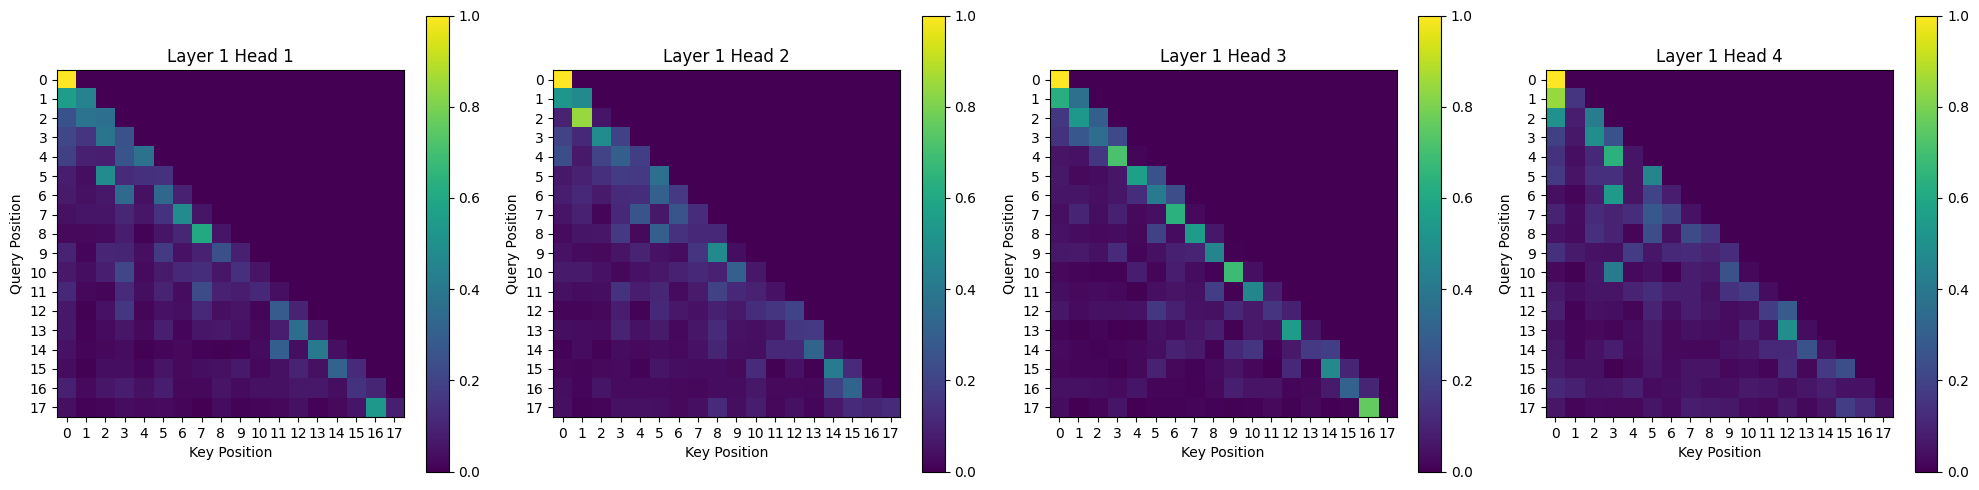

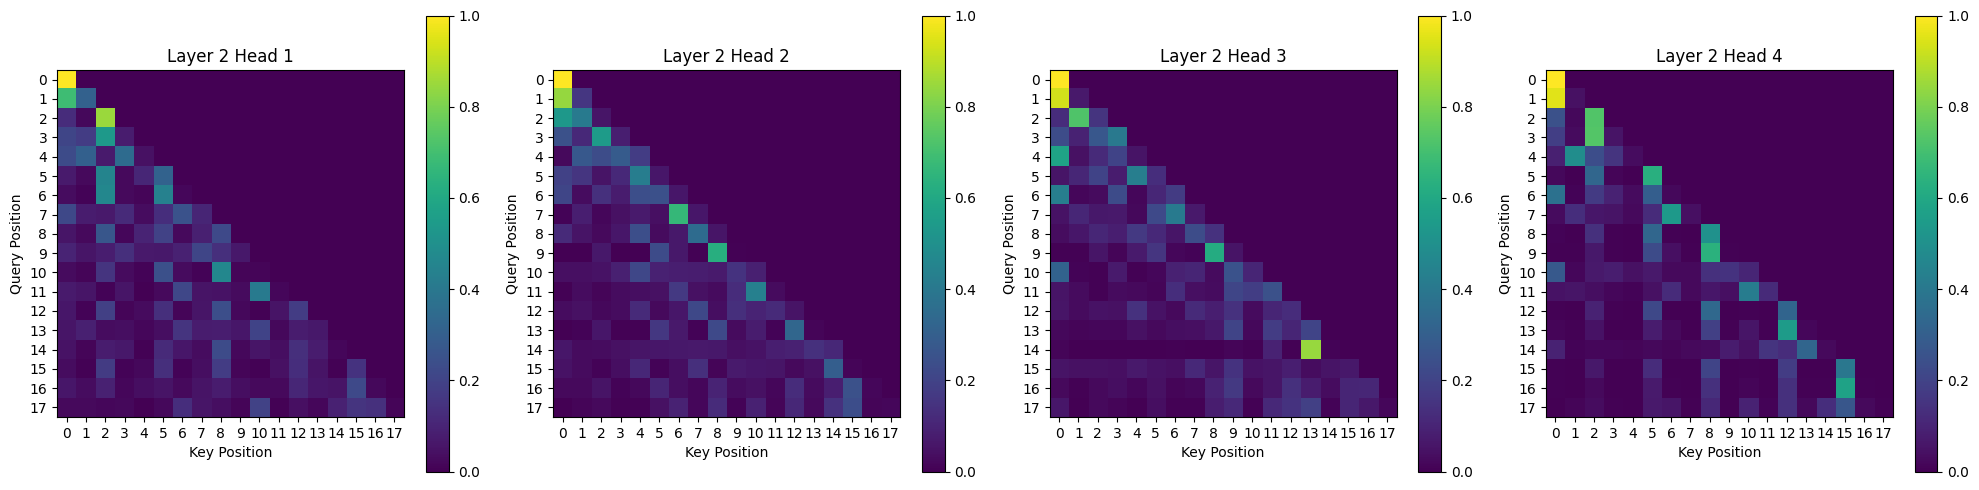

In [91]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

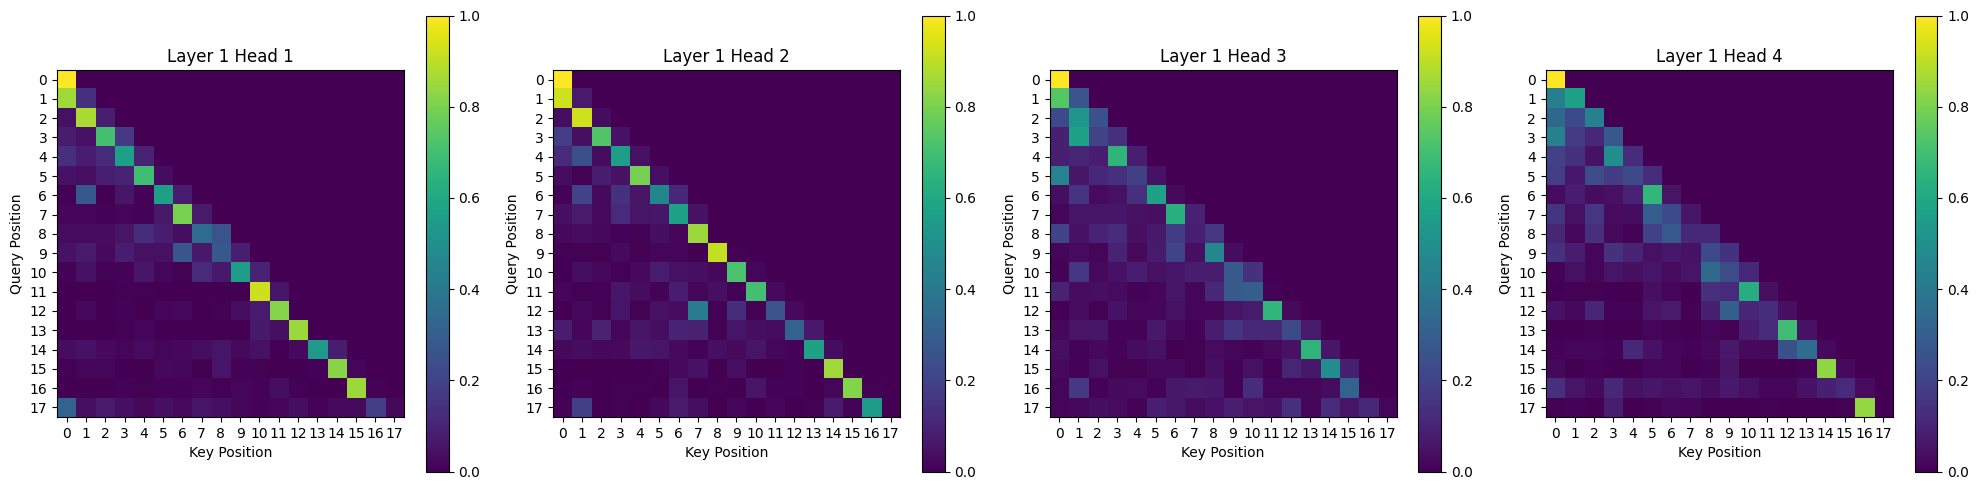

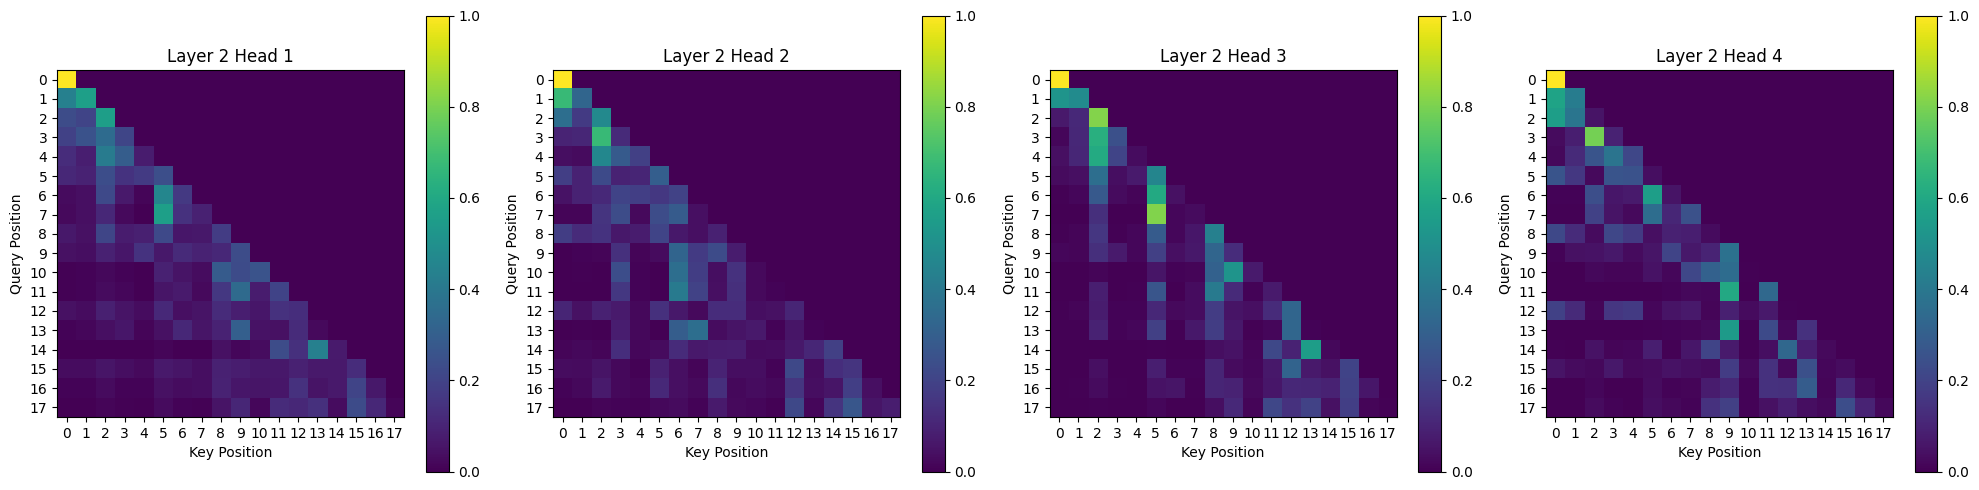

In [92]:
prompt = "To be or not to be"
visualize_attention(model_moe, prompt)

# Conclusiones

- Se comenzó con un modelo base tipo GPT sencillo, suficiente para pruebas preliminares, pero limitado en capacidad de generación de texto coherente.

- Se analizaron distintos esquemas de muestreo:
  - Greedy: genera texto coherente pero repetitivo.
  - Temperatura: ajusta aleatoriedad; valores altos diversifican, bajos estabilizan.
  - Top-k / Top-p: balance entre calidad y diversidad, evitando salidas triviales o erráticas.

- Intentos de mejora: Se probaron ajustes de hiperparámetros y tamaño del dataset original, con algunas mejoras leves aunque casi imperceptibles.

- Uso de MoE: La incorporación de Mixture of Experts permitió escalar el modelo sin aumentar linealmente los costos computacionales, intentando mejorar la capacidad de representación, aunque el resultado fue pobre en base a no haber escalado lo suficiente el modelo ni los datos de entrenamiento.


- Además de las posibles mejoras en el modelo original, caben destacar posibles mejoras en la clase Expert: Explorar activaciones más avanzadas (GeLU, SwiGLU), residual connections, o regularización adicional para mayor robustez.